In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import env_basketball

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn

In [4]:
import agent as agent
# import agent_flat as agent

In [5]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 1, 'n_defensive_players': 0})

In [6]:
net = agent.OffenseNet(env)
print('n_params: ', np.sum([p.numel() for p in net.parameters()]))

n_params:  3719


In [57]:
state = env.reset()

for t in range(50):
    # action = env_basketball.get_random_action(env, env.state)
    action = net.calc_action(state)
    state, reward, done, info = env.step(action)
    


In [58]:
ani, vid = env.render_episode(mode='vid', tqdm=tqdm)
vid

  0%|          | 0/51 [00:00<?, ?it/s]

0.6876031756401062


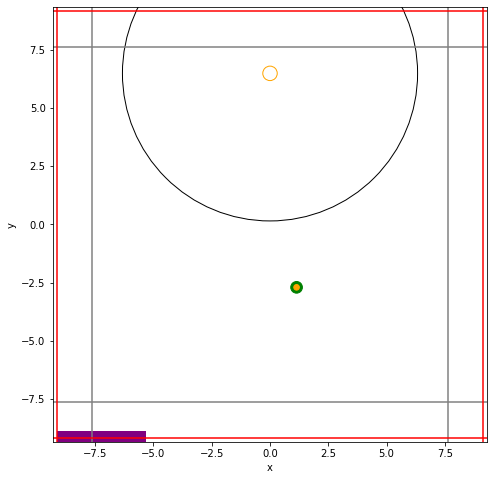

In [63]:
env.render()
print(env.evaluate_ppp())

torch.Size([3719])


In [7]:
def calc_fitness(v, net=net):
    state = env.reset()
    nn.utils.vector_to_parameters(v, net.parameters())
    for t in range(50):
        # action = env_basketball.get_random_action(env, env.state)
        action = net.calc_action(state)
        state, reward, done, info = env.step(action)
    return env.evaluate_ppp()

In [23]:
net = agent.OffenseNet(env)
v = nn.utils.parameters_to_vector(net.parameters())
v = torch.randn_like(v)/10.
print(v.shape)

torch.Size([3719])


In [24]:
[calc_fitness(v) for _ in range(10)]

[1.162099003791809,
 1.2285574674606323,
 1.492434024810791,
 1.269945740699768,
 1.4918980598449707,
 1.226524829864502,
 0.6853234171867371,
 0.7488009929656982,
 1.234823226928711,
 0.6546190977096558]

In [25]:
        
sigma = 1e-1
lr=1e-4

def calc_grad(v, n_pop=5):
    eps = torch.randn(n_pop, *v.shape)
    vs = v+eps*sigma
    Fs = torch.tensor([calc_fitness(vi) for vi in vs])
    Fns = (Fs-Fs.mean())/Fs.std()
    
    grad = 1./(n_pop*sigma)*(Fs[:, None]*eps).sum(dim=0)
    return Fs, grad

def run_es_adam(v, n_gen=100, n_pop=5):
    v = v.clone()
    opt = torch.optim.Adam([v], lr=1e-1)
    Fss = []
    pbar = tqdm(range(n_gen))
    for i in pbar:
        Fs, grad = calc_grad(v.detach().clone(), n_pop=n_pop)
        # print(Fs.min().item(), Fs.mean().item(), Fs.max().item())
        v.grad = -grad
        opt.step()
        Fss.append(Fs)
        # print(Fs.mean().item(), Fs.std().item())
        pbar.set_postfix({'Fs': Fs.mean().item()})
    return torch.stack(Fss)
    
    

In [26]:
fits = run_es_adam(v, n_gen=30, n_pop=100)

  0%|          | 0/30 [00:00<?, ?it/s]

In [28]:
[calc_fitness(v) for _ in range(10)]

[0.9614198803901672,
 1.073094129562378,
 0.7272970676422119,
 1.7026466131210327,
 1.5505750179290771,
 0.6668845415115356,
 0.822075605392456,
 0.7067844271659851,
 0.893059253692627,
 1.7995095252990723]

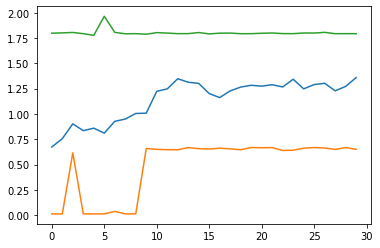

In [27]:
plt.plot(fits.mean(dim=-1))
plt.plot(fits.min(dim=-1).values)
plt.plot(fits.max(dim=-1).values)

In [ ]:
calc_fitness(v)